# New York Taxi Trip

This is a Kaggle Competition where in the objective is to predict the trip duration for records in the test dataset.
The train dataset has 1.45M records with fields such as:

1. id -- Identifier for the taxi trip
2. vendor_id -- a code indicating the provider associated with the trip record
3. pickup_datetime -- date and time when the meter was engaged
4. dropoff_datetime -- date and time when the meter was disengaged
5. passenger_count -- the number of passengers in the vehicle (driver entered value)
6. pickup_longitude -- the longitude where the meter was engaged
7. pickup_latitude -- the latitude where the meter was engaged
8. dropoff_longitude -- the longitude where the meter was disengaged
9. dropoff_latitude -- the latitude where the meter was disengaged
10. store_and_fwd_flag -- This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
11. trip_duration -- duration of the trip in seconds

We also have a test dataset for which we are going to predict the trip duration.The test dataset has 625k records

### Read the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train=pd.read_csv("train.csv")
# train['trip_time_in_mins']=train['trip_duration']/3660
test=pd.read_csv("test.csv")
train.count()

id                    1458644
vendor_id             1458644
pickup_datetime       1458644
dropoff_datetime      1458644
passenger_count       1458644
pickup_longitude      1458644
pickup_latitude       1458644
dropoff_longitude     1458644
dropoff_latitude      1458644
store_and_fwd_flag    1458644
trip_duration         1458644
dtype: int64

In [2]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Table Attributes

In [3]:
import datetime

R=6373.0

def format_data(arg):
    
    # First step is to calculate the distance between the points
    lat1=np.radians(np.array(arg['dropoff_latitude']))
    lat2=np.radians(np.array(arg['pickup_latitude']))
    lon1=np.radians(np.array(arg['dropoff_longitude']))
    lon2=np.radians(np.array(arg['pickup_longitude']))
    temp1=lon1-lon2
    temp2=lat1-lat2
    temp3=(np.sin(temp2/2))**2 +(np.cos(lat1)*np.cos(lat2)*(np.sin(temp1/2))**2)
    temp4=2*np.arctan2(np.sqrt(temp3),np.sqrt(1-temp3))
    arg['dist_km']=pd.DataFrame(R*temp4)

    
    # Second Step is to get the day of week and hour of day from the pickup and dropoff time stamps
    arg['day_of_week']=pd.to_datetime(arg['pickup_datetime']).dt.dayofweek
    
    # Third, Lets get the hour of time
    arg['hour_of_day']=pd.to_datetime(arg['pickup_datetime']).dt.hour
    
    # Fourth, Lets add the day of the trip
    arg['date_of_trip']=pd.to_datetime(arg['pickup_datetime']).dt.date
    
        
format_data(train)
format_data(test)


test=test[['day_of_week','hour_of_day','date_of_trip','store_and_fwd_flag','dist_km','passenger_count','vendor_id','id']]

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_km,day_of_week,hour_of_day,date_of_trip
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498991,0,17,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.806074,6,0,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.387103,1,11,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485965,2,19,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188962,5,13,2016-03-26


### Exploratory Data Analysis

    1. Exploring the Passenger_count

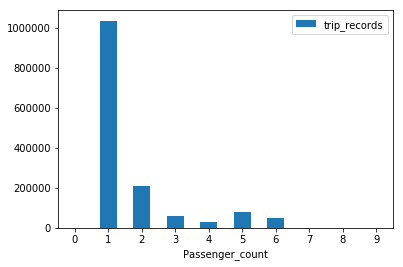

In [5]:
temp=train[['passenger_count','trip_duration']].groupby('passenger_count',as_index=False).count()
temp.columns=['Passenger_count','trip_records']
temp.set_index(['Passenger_count'],inplace=True)
temp.plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Passenger_count')

* Based on the above chart, we can see that there are records with 0 Passenger counts and also with 7,8 and 9. 
* A normal Taxi can carry a max of 6 passenger (in case of mini van)
* Ignoring all the 0 Passenger count records and all passenger_counts greater than 6

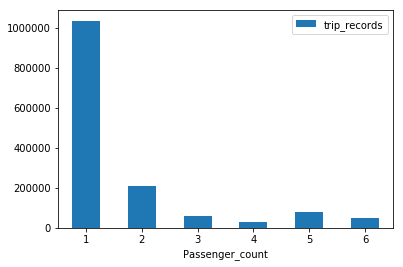

In [6]:
# Keeping only the records with passenger counts < 7
train=train.loc[(train['passenger_count'] < 7 )]

# Also elimimnating the records with passenger_counts=0
train=train.loc[train['passenger_count']!= 0]

# Lets take a look at the data again to ensure the removal occurred without any surprises
temp=train[['passenger_count','trip_duration']].groupby('passenger_count',as_index=False).count()
temp.columns=['Passenger_count','trip_records']
temp.set_index(['Passenger_count'],inplace=True)
temp
temp.plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Passenger_count')

    2. Exploring the dist_km variable

* Dist_km is calculated using haversine formula to calculate the distance from the longitudes and latitudes available.
* From the data it looks like there are 5897 records with the same longitudes and latitudes for pickup and dropoff.
* Eventhough it is possible that these trip are legitimate with the trip being retur trips, for our purposes, we will be dropping these to ensure the variance in the model reduces

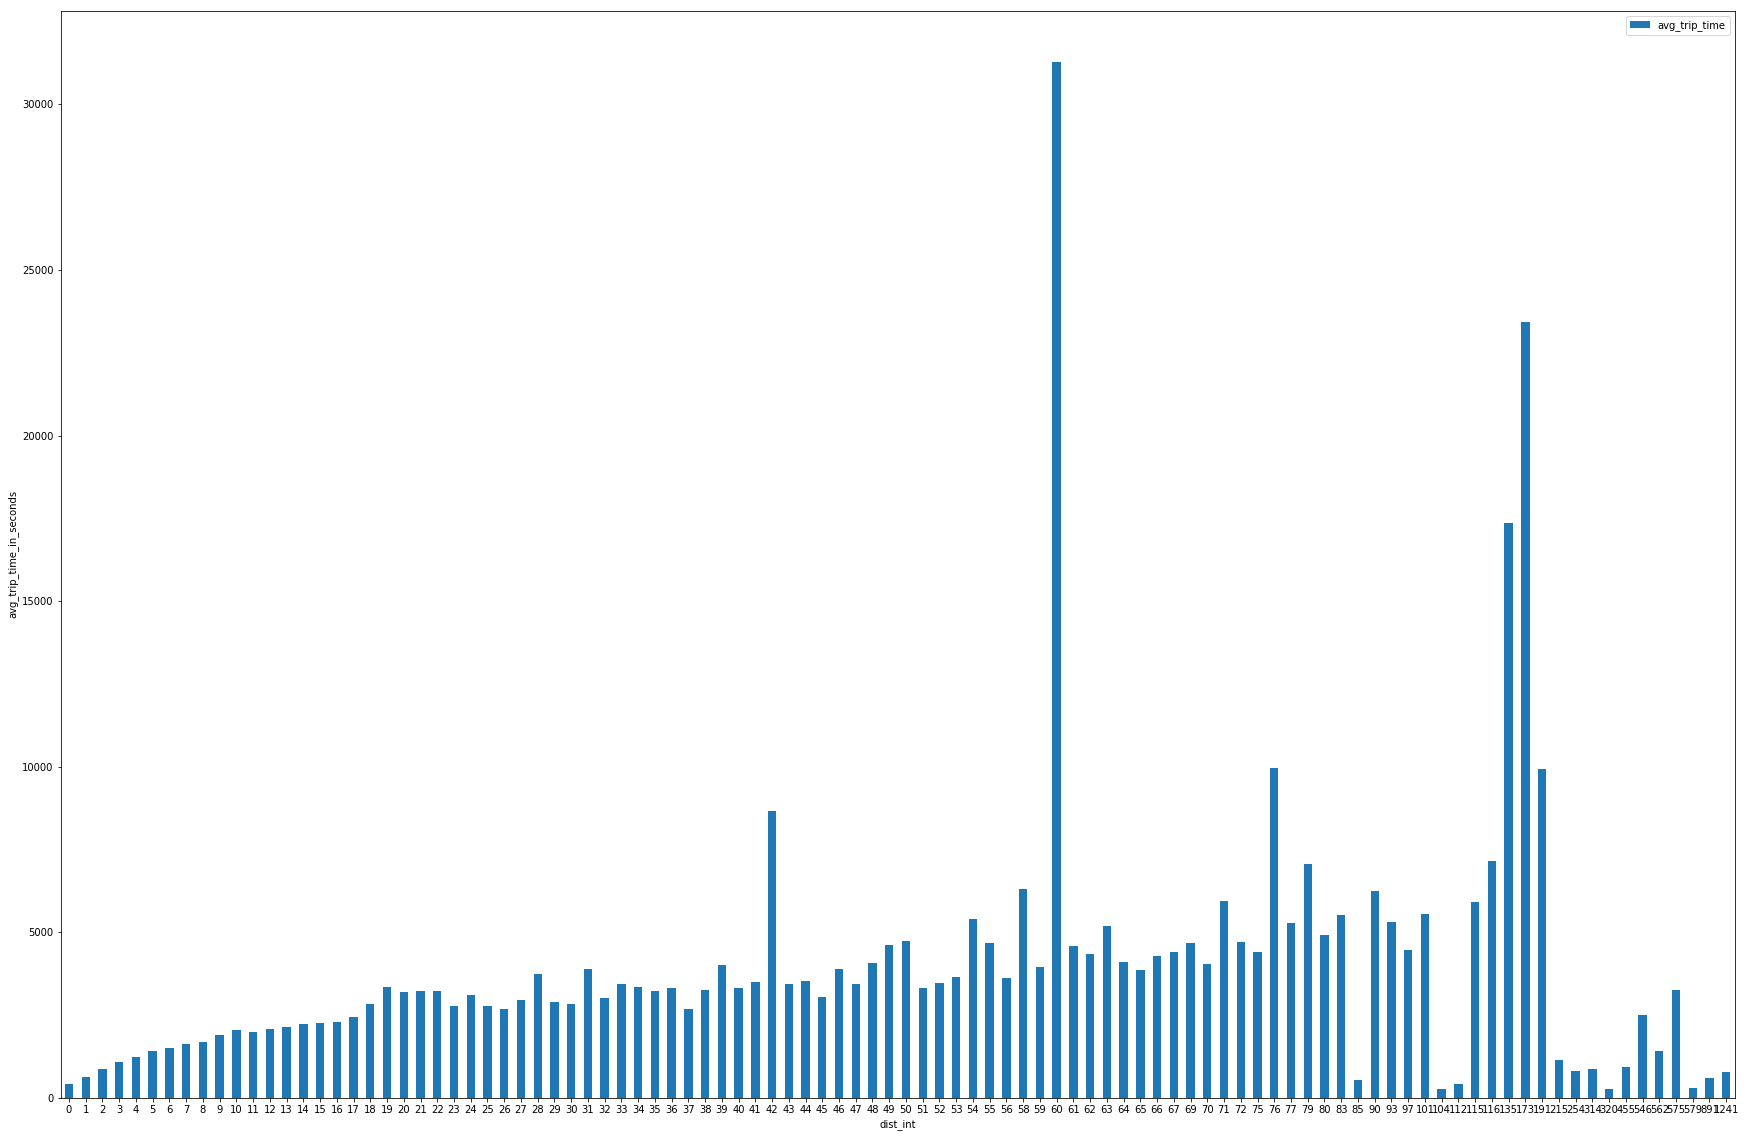

In [7]:
train=train.loc[train['dist_km']>0]
train['dist_int']=train['dist_km'].apply(int)
train=train[['day_of_week','hour_of_day','store_and_fwd_flag','dist_km','passenger_count','vendor_id','trip_duration','dist_int']]
train.head()

temp=train[['dist_int','trip_duration']].groupby('dist_int',as_index=False).mean()
temp.columns=['dist_int','avg_trip_time']
temp.set_index(['dist_int'],inplace=True)
temp
temp.plot.bar(figsize=(30,20))
plt.xticks(rotation=0)
plt.ylabel('avg_trip_time_in_seconds')
plt.xlabel('dist_int')
# temp=train[['dist_int','passenger_count']].groupby('dist_int',as_index=False).count()
# temp.columns=['dist_int','trip_records']
# temp.set_index(['dist_int'],inplace=True)
# temp[temp['trip_records']<10]

* Based on the graph above, we find that there are records where the rounded distance > 400 Km which is roughly the distance to washington. For our model purposes, I would be eliminating all the records where the distance of trip is greater than or equal to 400KM. 

* Also based on the average trip duration and trip distance they do not make sense

In [8]:
# Eliminating records with trip distance greater than or equal to 400 KM
train=train[train['dist_km']<400]

There are a few outlier as well in the data looking at the chart above.
For example the trip distance=60 the average trip duration spikes.
Lets look at some of these individually

In [9]:
train[train['dist_int']==60]

,day_of_week,hour_of_day,store_and_fwd_flag,dist_km,passenger_count,vendor_id,trip_duration,dist_int
673634,4,2,N,60.988487,1,1,3041,60
900381,5,13,N,60.617209,5,2,85561,60
1257988,3,23,N,60.965994,1,1,5201,60


Here there is a trip record where the trip distance and trip duration do not align to intuition. The trip duration of 85561 for a distance of 60.61KM could be due to external reasons such as traffic jam (One hell of a traffic jam!!!) or the now famous New York Snow day. 

But for the sake of more context, lets look at more of such occurences
1. First there are 4 records with trip duration >200000 seconds which is greater than 2 Days. Lets eliminate these records

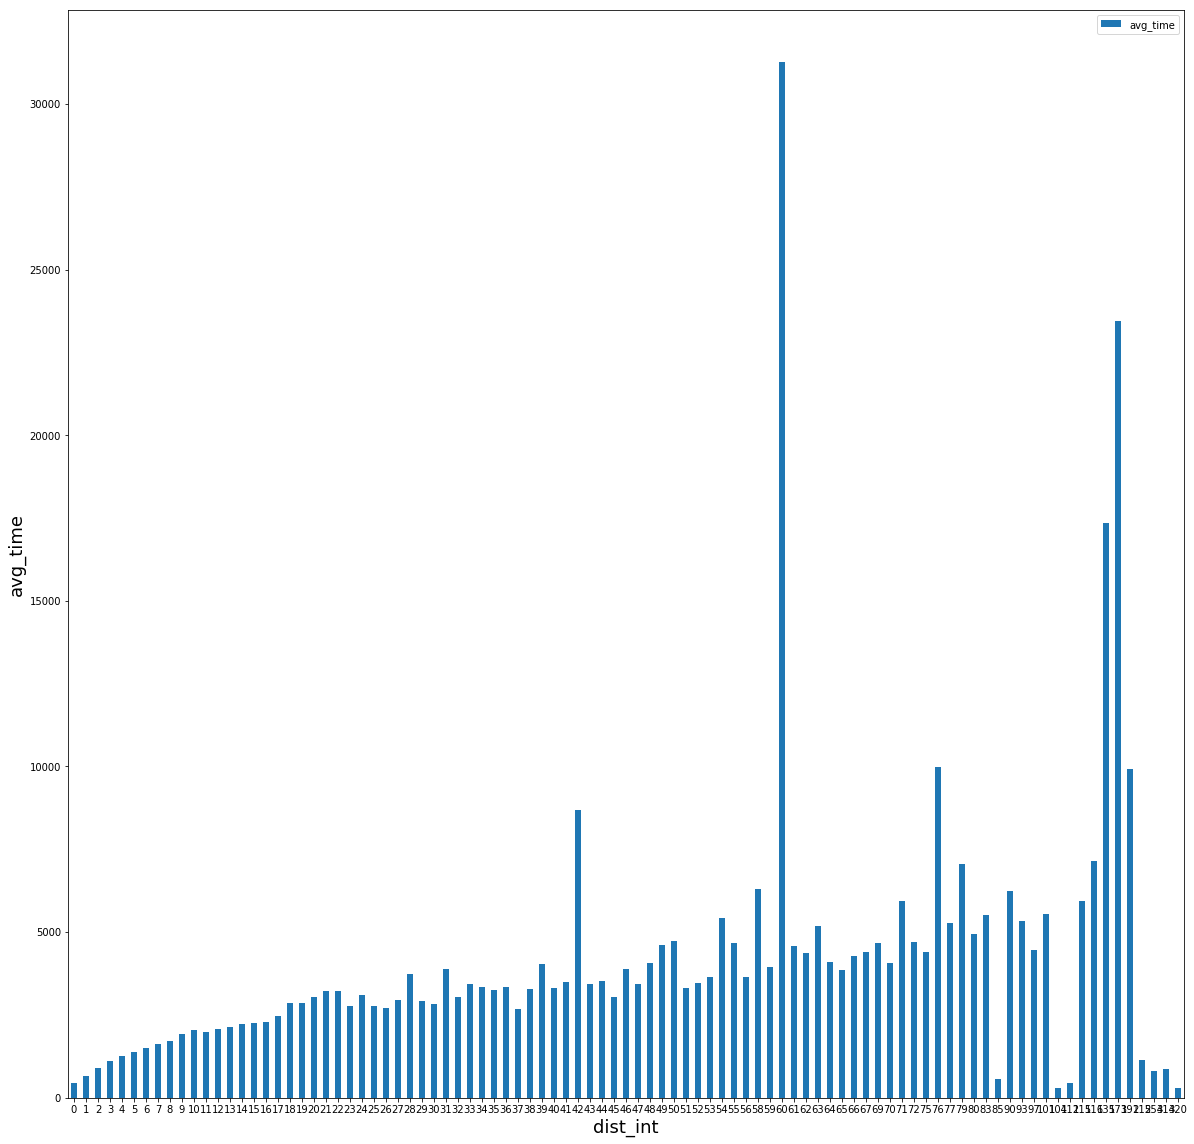

In [10]:
# Remove trip_duration>200000 outliers

train=train[train['trip_duration']<200000]

# Replotting the grapph after removing the 4 observations
temp=train[['dist_int','trip_duration']].groupby('dist_int',as_index=False).mean()
temp.columns=['dist_int','avg_time']
temp.set_index(['dist_int'],inplace=True)
temp
temp.plot.bar(figsize=(20,20))
plt.xticks(rotation=0)
plt.ylabel('avg_time', fontsize=18)
plt.xlabel('dist_int', fontsize=18)

Lets eliminate some more more records with trip duration greater than 20000
    * There are 2060 such records that we can eliminiate since these are skewing our results
    * There also are records for trip distance in (85,104) km where the trip duration does not make sense.
    * Lets also eliminate them
    * Lets plot out the Graph again

In [11]:
temp=train[train['trip_duration']>20000].count()
train=train[train['trip_duration']<20000]
temp

day_of_week           2060
hour_of_day           2060
store_and_fwd_flag    2060
dist_km               2060
passenger_count       2060
vendor_id             2060
trip_duration         2060
dist_int              2060
dtype: int64

In [12]:
temp=train[(train['dist_int']>=85) & (train['trip_duration']<1000)]

temp
# temp=train[['dist_int','trip_duration']].groupby('dist_int',as_index=False).mean()
# temp.columns=['dist_int','avg_time']
# temp.set_index(['dist_int'],inplace=True)
# temp
# temp.plot.bar(figsize=(20,20))
# plt.xticks(rotation=0)
# plt.ylabel('avg_time', fontsize=18)
# plt.xlabel('dist_int', fontsize=18)

,day_of_week,hour_of_day,store_and_fwd_flag,dist_km,passenger_count,vendor_id,trip_duration,dist_int
275644,2,16,N,314.863015,4,1,875,314
283102,6,16,N,112.584203,1,2,427,112
377068,5,20,N,320.226270,1,1,282,320
595540,6,21,N,104.792857,1,1,279,104
644165,3,15,N,254.443373,1,2,804,254
1359910,3,18,N,85.911837,1,1,548,85


In [13]:
train=train.merge(temp[['dist_int','trip_duration','passenger_count']],how='left',on=['dist_int','trip_duration'])
train=train[train['passenger_count_y'].isnull()]
del train['passenger_count_y']

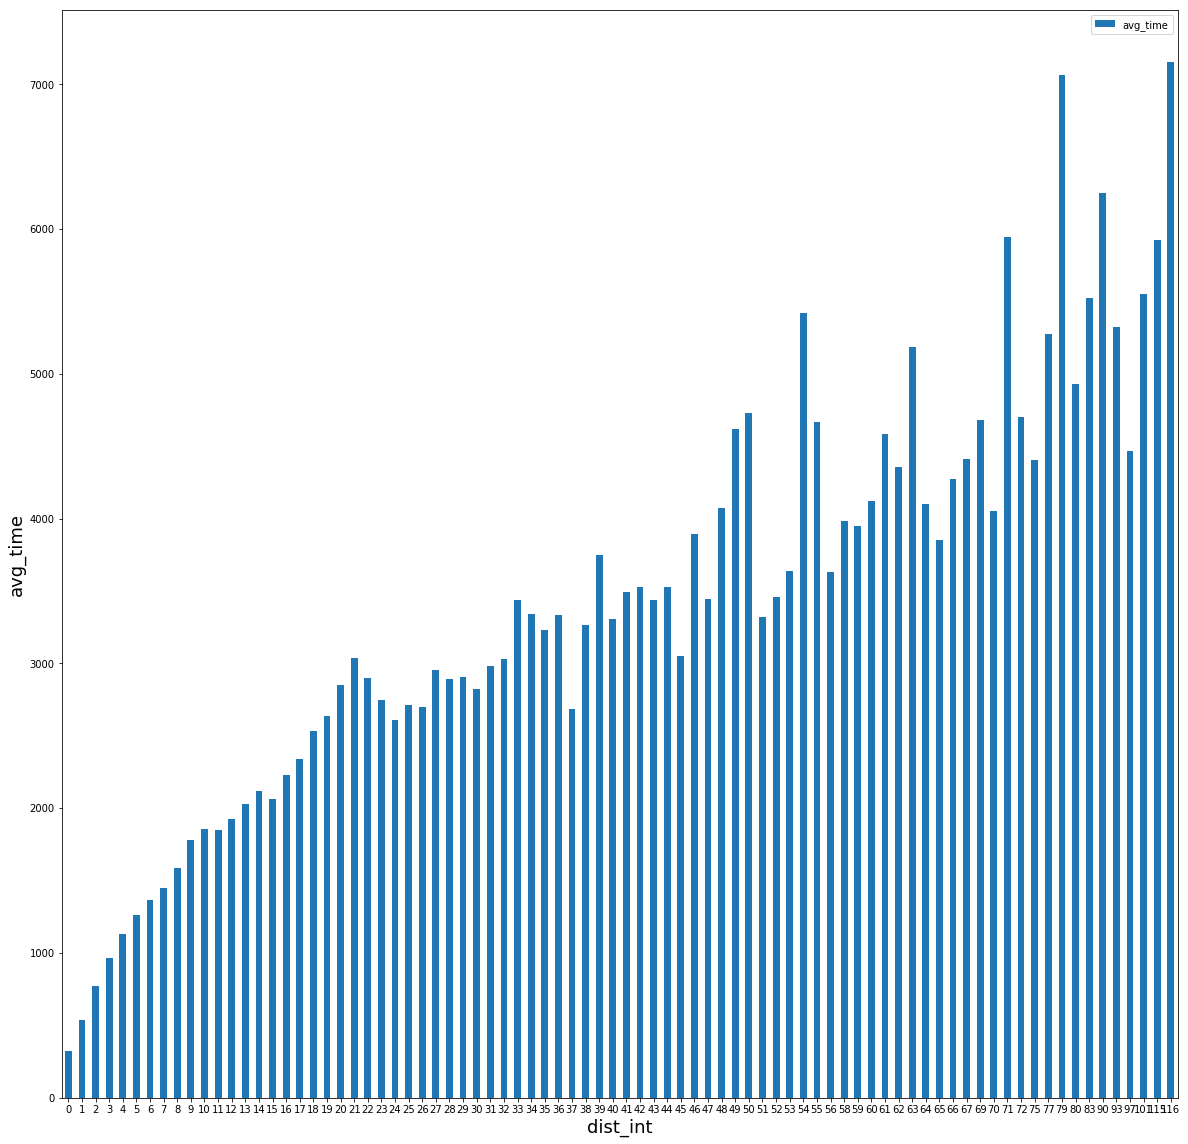

In [14]:
train=train[(train['trip_duration']<8000) & (train['dist_int']<215)]
# Replotting the grapph after removing the 4 observations
temp=train[['dist_int','trip_duration']].groupby('dist_int',as_index=False).mean()
temp.columns=['dist_int','avg_time']
temp.set_index(['dist_int'],inplace=True)
temp
temp.plot.bar(figsize=(20,20))
plt.xticks(rotation=0)
plt.ylabel('avg_time', fontsize=18)
plt.xlabel('dist_int', fontsize=18)

In [15]:
# del train['dist_int']
train.head()

,day_of_week,hour_of_day,store_and_fwd_flag,dist_km,passenger_count_x,vendor_id,trip_duration,dist_int
0,0,17,N,1.498991,1,2,455,1
1,6,0,N,1.806074,1,1,663,1
2,1,11,N,6.387103,1,2,2124,6
3,2,19,N,1.485965,1,2,429,1
4,5,13,N,1.188962,1,2,435,1


    3. Exploring the day_of_week variable

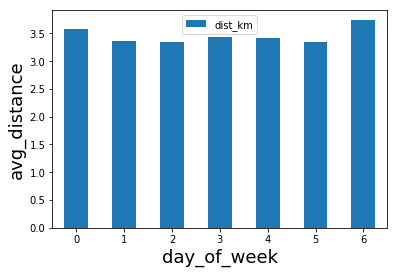

In [16]:
day_of_week=train[['day_of_week','dist_km']].groupby('day_of_week').mean()
day_of_week.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('avg_distance', fontsize=18)
plt.xlabel('day_of_week', fontsize=18)

Looking at the table below the data looks sensible.
* 0 being Monday and 6 being Sunday, the travel times seem to make sense somewhat--(less on weekends compared to weekdays)
* Also in the next table, the number of trip are more for Fridays and Saturday.
    

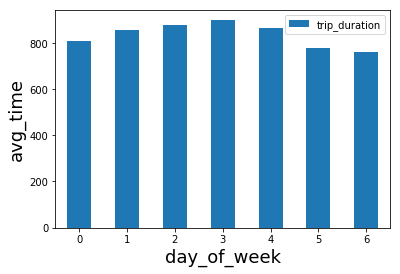

In [17]:
day_of_week=train[['day_of_week','trip_duration']].groupby('day_of_week').mean()
day_of_week.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('avg_time', fontsize=18)
plt.xlabel('day_of_week', fontsize=18)

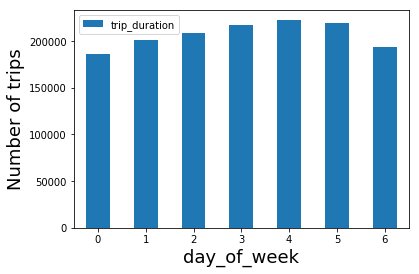

In [18]:
day_of_week=train[['day_of_week','trip_duration']].groupby('day_of_week').count()
day_of_week.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of trips', fontsize=18)
plt.xlabel('day_of_week', fontsize=18)

    4. Exploring Hour of Day
    * The graph plotted below is not very useful since it is quite big
    * Lets plot them by Day

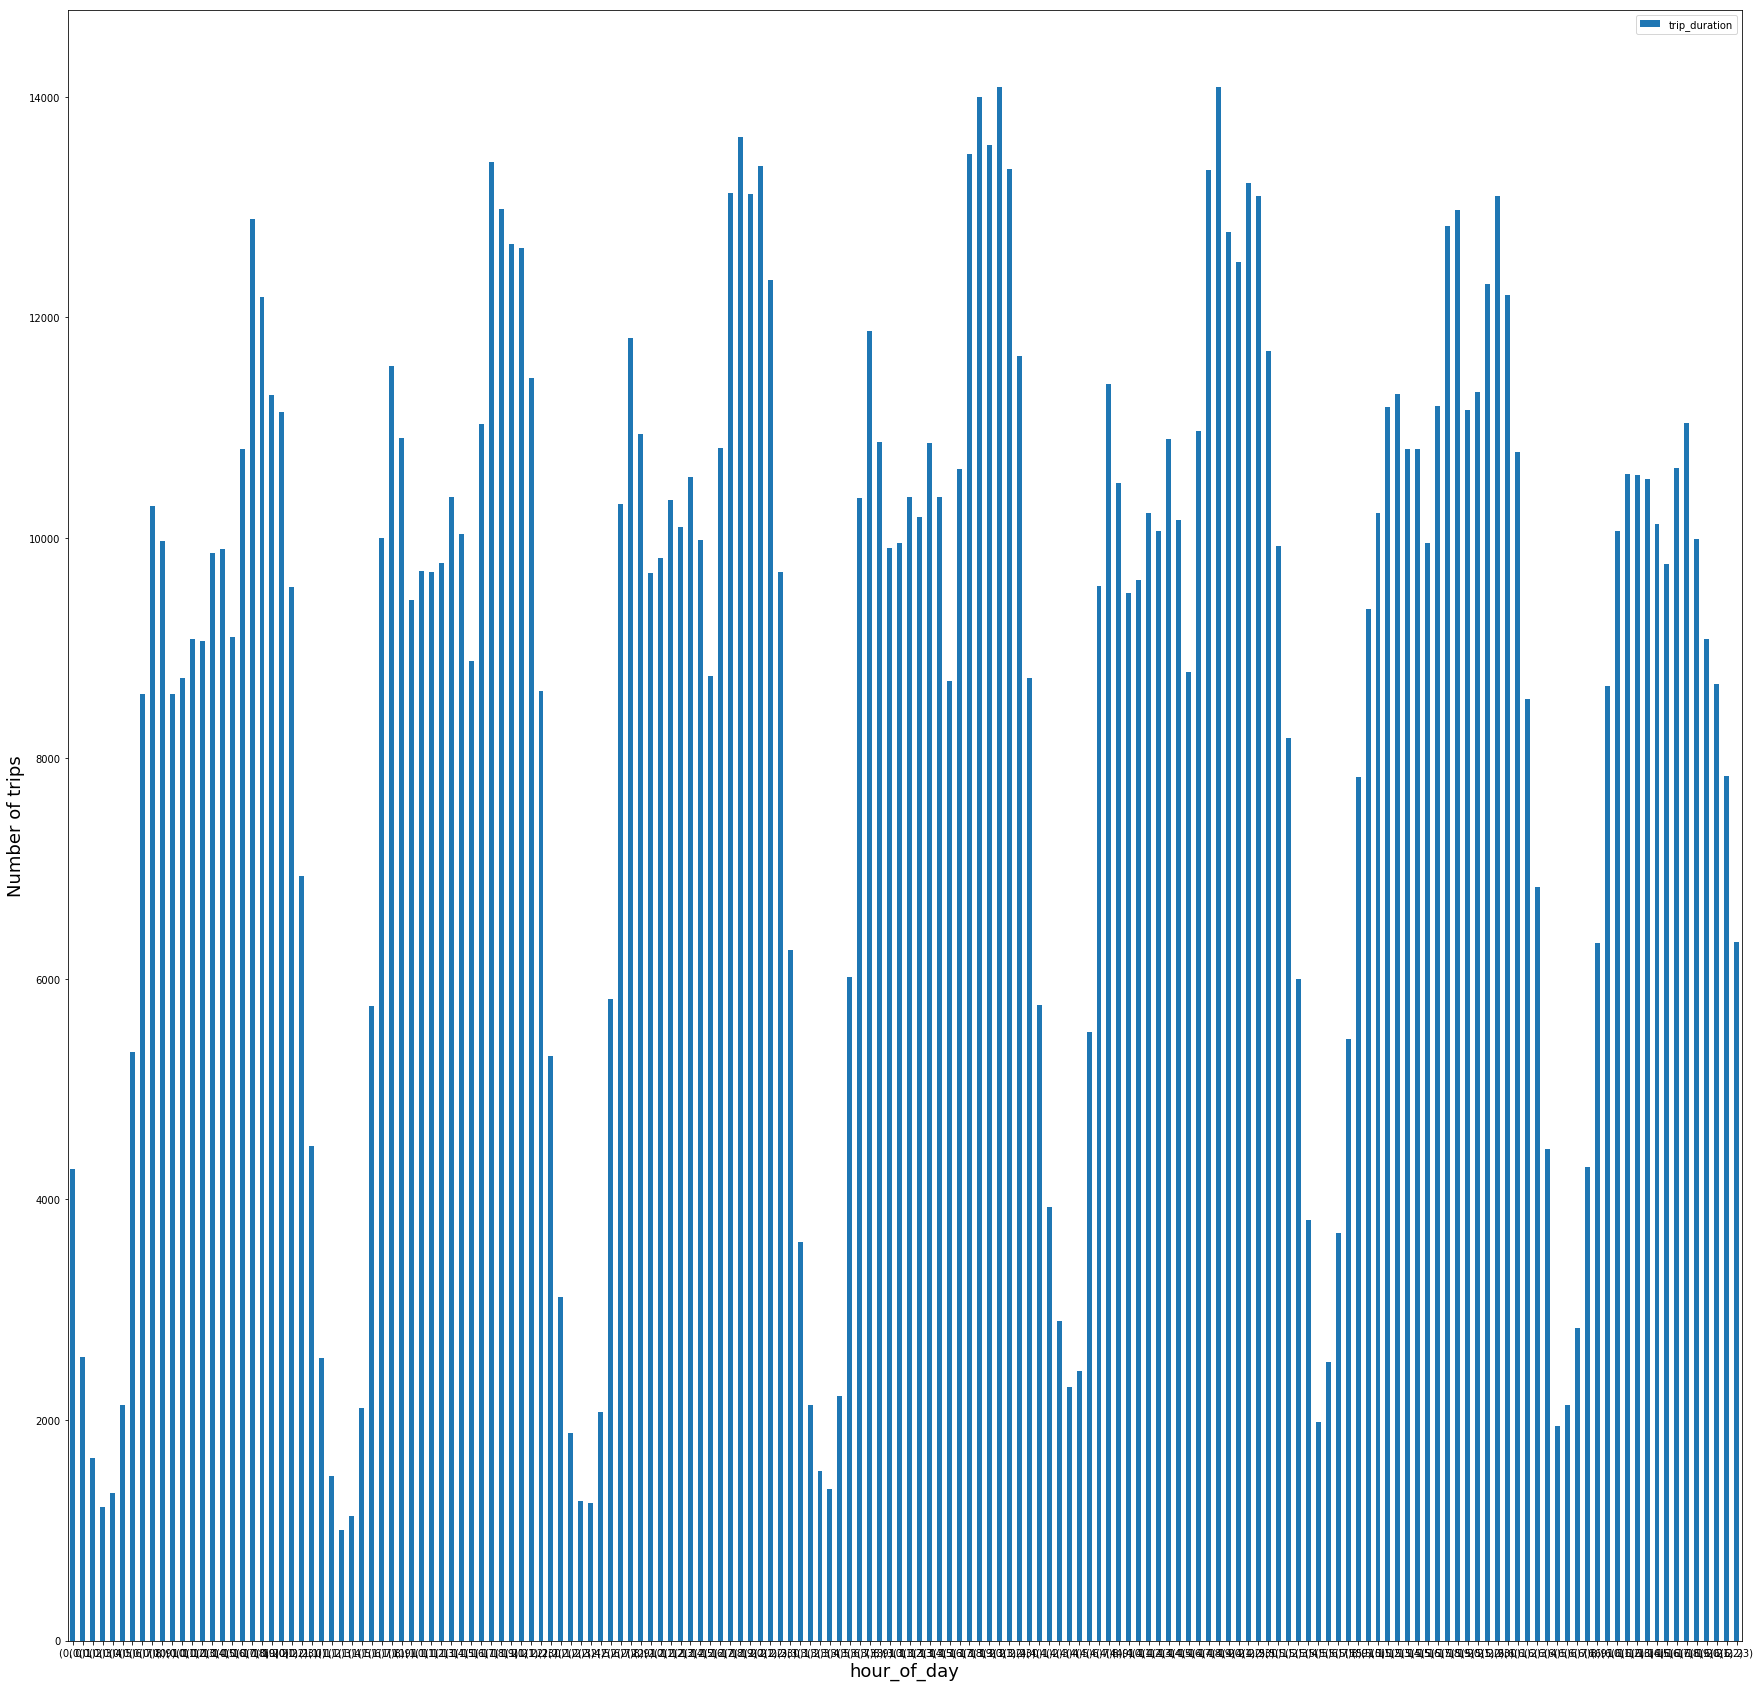

In [19]:
hour_of_day=train[['day_of_week','hour_of_day','trip_duration']].groupby(['day_of_week','hour_of_day']).count()
hour_of_day.plot.bar(stacked=True,sort_columns=True,figsize=(30,30))
plt.xticks(rotation=0)
plt.ylabel('Number of trips', fontsize=18)
plt.xlabel('hour_of_day', fontsize=18)

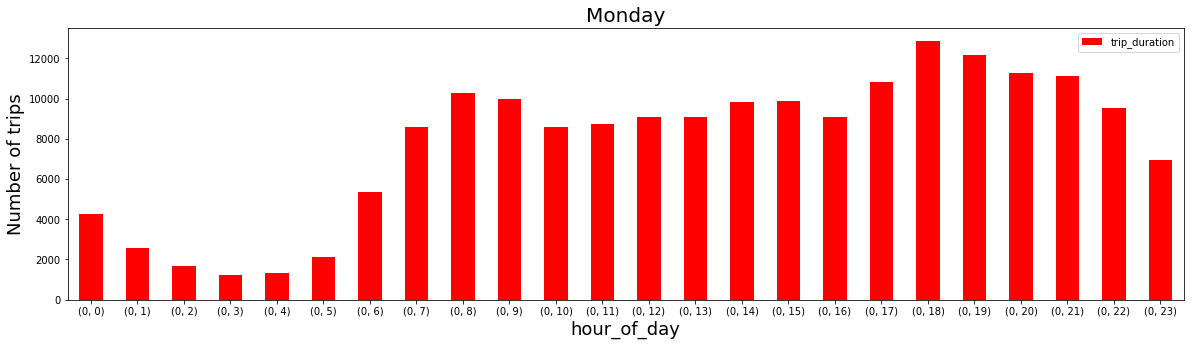

In [20]:
hour_of_day=train[train['day_of_week']==0][['day_of_week','hour_of_day','trip_duration']].groupby(['day_of_week','hour_of_day']).count()
hour_of_day.plot.bar(stacked=True,colormap='prism',sort_columns=True,figsize=(20,5))
plt.xticks(rotation=0)
plt.title("Monday",fontsize=20)
plt.ylabel('Number of trips', fontsize=18)
plt.xlabel('hour_of_day', fontsize=18)

From daily charts, Monday-Thursday peaks are at 1800 and 1900 Hr mark, relating to regular work end times and party hours 2100- 0000 Hours trend downwards

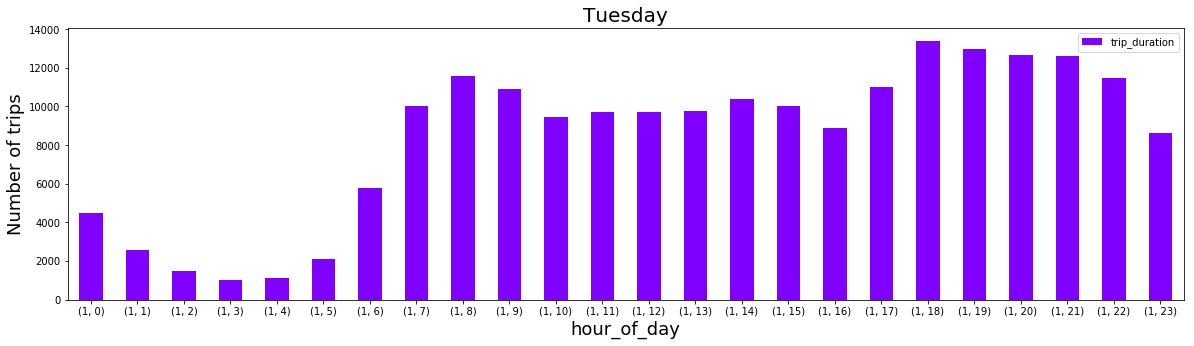

In [21]:
hour_of_day=train[train['day_of_week']==1][['day_of_week','hour_of_day','trip_duration']].groupby(['day_of_week','hour_of_day']).count()
hour_of_day.plot.bar(stacked=True,colormap='rainbow',sort_columns=True,figsize=(20,5))
plt.xticks(rotation=0)
plt.title("Tuesday",fontsize=20)
plt.ylabel('Number of trips', fontsize=18)
plt.xlabel('hour_of_day', fontsize=18)

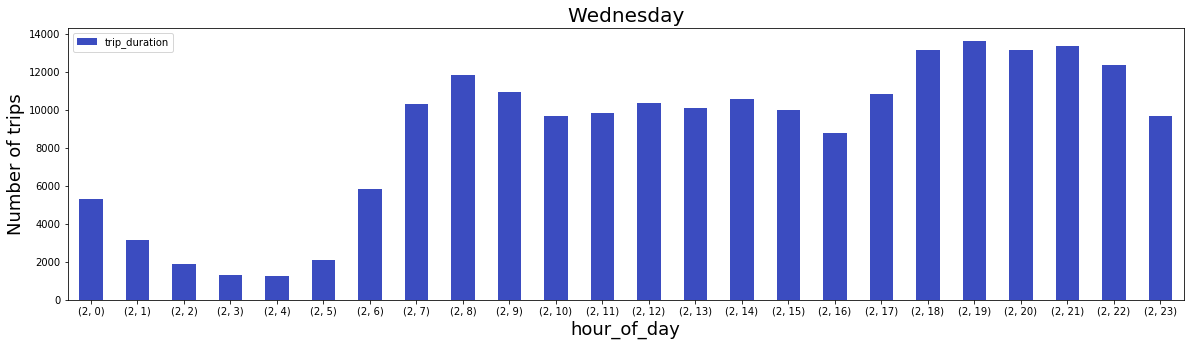

In [22]:
hour_of_day=train[train['day_of_week']==2][['day_of_week','hour_of_day','trip_duration']].groupby(['day_of_week','hour_of_day']).count()
hour_of_day.plot.bar(stacked=True,colormap='coolwarm',sort_columns=True,figsize=(20,5))
plt.xticks(rotation=0)
plt.title("Wednesday",fontsize=20)
plt.ylabel('Number of trips', fontsize=18)
plt.xlabel('hour_of_day', fontsize=18)

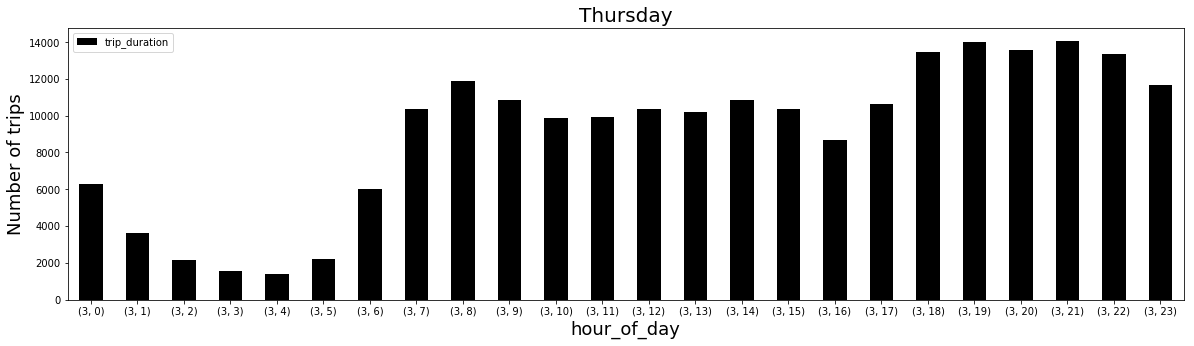

In [23]:
hour_of_day=train[train['day_of_week']==3][['day_of_week','hour_of_day','trip_duration']].groupby(['day_of_week','hour_of_day']).count()
hour_of_day.plot.bar(stacked=True,colormap='CMRmap',sort_columns=True,figsize=(20,5))
plt.xticks(rotation=0)
plt.title("Thursday",fontsize=20)
plt.ylabel('Number of trips', fontsize=18)
plt.xlabel('hour_of_day', fontsize=18)

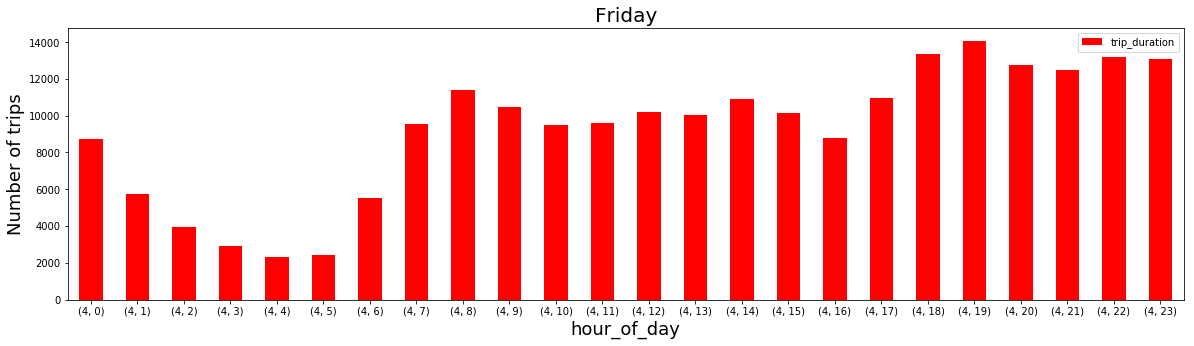

In [24]:
hour_of_day=train[train['day_of_week']==4][['day_of_week','hour_of_day','trip_duration']].groupby(['day_of_week','hour_of_day']).count()
hour_of_day.plot.bar(stacked=True,colormap='prism',sort_columns=True,figsize=(20,5))
plt.xticks(rotation=0)
plt.title("Friday",fontsize=20)
plt.ylabel('Number of trips', fontsize=18)
plt.xlabel('hour_of_day', fontsize=18)

We See the weekday trends shifting for Friday, Saturday and Sundays.

There are higher number of trips taken in the time frames of 2100-0000 Hrs compared to weekdays.
Infact for Saturdays, the peaks are at 2300 and 0000 Hours (PARTY!!!)
Same for Sunday 0000, Early Sunday Party Hours.

Also checkout the trips trend higher for afterParty hours for Saturday and Sunday early mornings!!! 

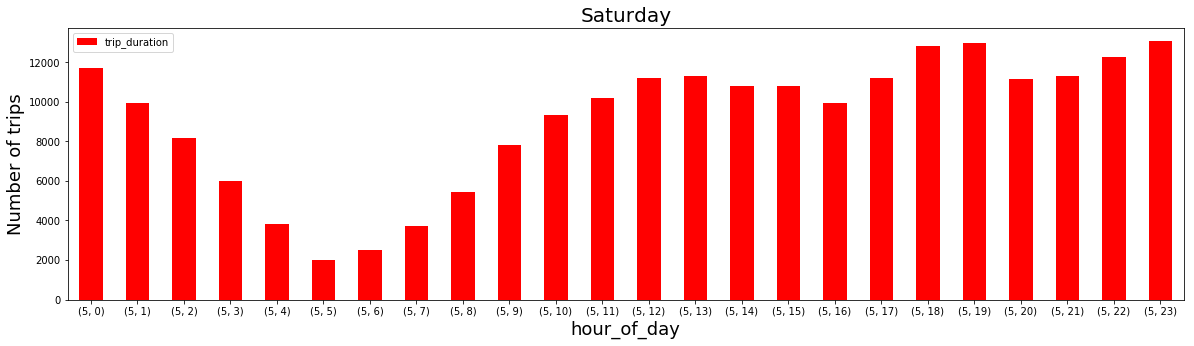

In [25]:
hour_of_day=train[train['day_of_week']==5][['day_of_week','hour_of_day','trip_duration']].groupby(['day_of_week','hour_of_day']).count()
hour_of_day.plot.bar(stacked=True,colormap='prism',sort_columns=True,figsize=(20,5))
plt.xticks(rotation=0)
plt.title("Saturday",fontsize=20)
plt.ylabel('Number of trips', fontsize=18)
plt.xlabel('hour_of_day', fontsize=18)

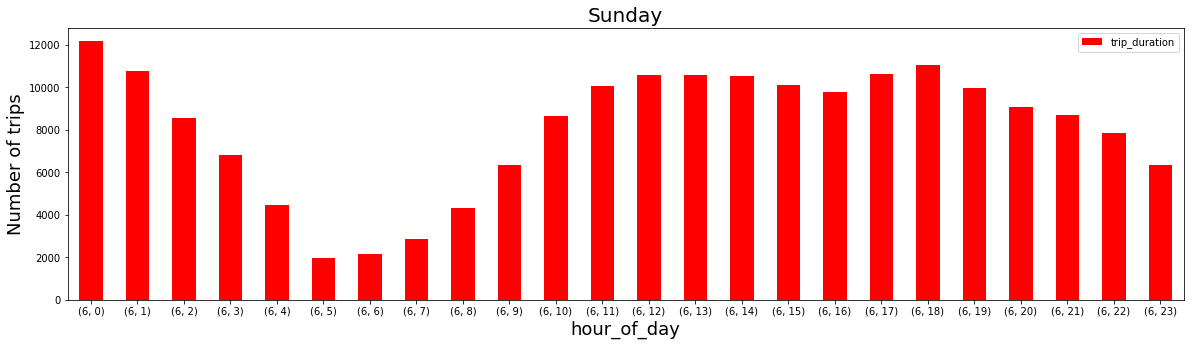

In [26]:
hour_of_day=train[train['day_of_week']==6][['day_of_week','hour_of_day','trip_duration']].groupby(['day_of_week','hour_of_day']).count()
hour_of_day.plot.bar(stacked=True,colormap='prism',sort_columns=True,figsize=(20,5))
plt.xticks(rotation=0)
plt.title("Sunday",fontsize=20)
plt.ylabel('Number of trips', fontsize=18)
plt.xlabel('hour_of_day', fontsize=18)

    5. Exploring the variable store_and_fwd_flag
    We would only be taking a quick look at the variable counts to see if we are missing any records.

In [27]:
train[['store_and_fwd_flag','passenger_count_x']].groupby('store_and_fwd_flag').count()

,passenger_count_x
store_and_fwd_flag,
N,1442514
Y,7976


## Lets create our final Training Data

In [28]:
train['trip_duration_mins']=train['trip_duration']/60
train=train[['day_of_week','hour_of_day','store_and_fwd_flag','dist_km','passenger_count_x','vendor_id','trip_duration_mins']]
train.columns=['day_of_week','hour_of_day','store_and_fwd_flag','dist_km','passenger_count','vendor_id','trip_duration_mins']
train.head()

,day_of_week,hour_of_day,store_and_fwd_flag,dist_km,passenger_count,vendor_id,trip_duration_mins
0,0,17,N,1.498991,1,2,7.583333
1,6,0,N,1.806074,1,1,11.050000
2,1,11,N,6.387103,1,2,35.400000
3,2,19,N,1.485965,1,2,7.150000
4,5,13,N,1.188962,1,2,7.250000


1. Converting the Categorical Variables 'day_of_week','hour_of_day' and 'store_and_fwd_flag' into numerical variables by OneHotEncoding and dropping one column to avoid Dummy Variable Trap

2. Next Splitting the dataset into X_Train and X_test

In [29]:

X=train.iloc[:, 0:6].values
Y=train.iloc[:,6].values
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


labelencoder_X_1 = LabelEncoder()
X[:, 2] = labelencoder_X_1.fit_transform(X[:, 2])

labelencoder_X_2 = LabelEncoder()
X[:, 0] = labelencoder_X_2.fit_transform(X[:, 0])

labelencoder_X_3 = LabelEncoder()
X[:, 1] = labelencoder_X_3.fit_transform(X[:, 1])

onehotencoder = OneHotEncoder(categorical_features = [0,1,2])


X = onehotencoder.fit_transform(X).toarray()

X=np.delete(X,[2],axis=1)
X.shape

(1450490, 35)

In [30]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3)


from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)


X_train.shape

(1015343, 35)

### Artificial Neural Network

1. Since this is a Regression Problem, we are using a KerasRegressor to predict the final continuous variable "Trip_duration"

2. KerasRegression allows us to build in Kfold validation process as well.

3. Since the KerasRegression takes in a function for argument, we have to create a function (baseline_model) here to build, initialize and compile the ANN

4. This ANN consists of 6 hidden layer with 35 input nodes and uses a Relu Activation function.

5. Adam as optimizer and mean_squared_error as our loss measuring functiton for back propagation, we are ready to train the model with 10000 epochs and a batch size of 1000.

6. FInally measuring the Mean Absolute error for out X_test dataset

In [31]:

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline


def baseline_model():
    model = Sequential()
    model.add(Dense(35, input_dim=35, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(35,kernel_initializer="glorot_uniform",activation='relu'))
    model.add(Dense(35,kernel_initializer="glorot_uniform",activation='relu'))
    model.add(Dense(35,kernel_initializer="glorot_uniform",activation='relu'))
    model.add(Dense(35,kernel_initializer="glorot_uniform",activation='relu'))
    model.add(Dense(35,kernel_initializer="glorot_uniform",activation='relu'))
    model.add(Dense(1, kernel_initializer='glorot_uniform'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
    

estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=10000, batch_size=1000,verbose=0)
kfold = KFold(n_splits=10, random_state=0)
results = cross_val_score(estimator, X_train, Y_train, cv=kfold, n_jobs=-1)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Using TensorFlow backend.


Results: 33.72 (0.47) MSE


In [32]:
estimator.fit(X_train,Y_train)
prediction=estimator.predict(X_test)

In [33]:
from keras import metrics
import tensorflow as tf
mae=metrics.mae(Y_test,prediction)
tf.InteractiveSession()
mae.eval()

3.8405571069144768

## Formating our Test or to be predicted Dataset

Since the input test dataset should be the same format as the training dataset used to train our model, lets do the following:

1. Use One Hot Encoder to encode the same three variables to convert the categorical variables to numerical

2. Standardize the variables using the same StandardScaler object created earlier.

3. Finally predict the test_dataset using the same model that was trained.

4. Export the output prediction into a csv with the necessary fields "newyorktaxitrip_output"

In [34]:
del test['date_of_trip']
test.head()

,day_of_week,hour_of_day,store_and_fwd_flag,dist_km,passenger_count,vendor_id,id
0,3,23,N,2.747288,1,1,id3004672
1,3,23,N,2.760105,1,1,id3505355
2,3,23,N,1.306565,1,1,id1217141
3,3,23,N,5.270742,1,2,id2150126
4,3,23,N,0.961143,1,1,id1598245


In [35]:
predict_X=test.iloc[:, 0:6].values

from sklearn.preprocessing import LabelEncoder, OneHotEncoder


labelencoder_X_1 = LabelEncoder()
predict_X[:, 2] = labelencoder_X_1.fit_transform(predict_X[:, 2])

labelencoder_X_2 = LabelEncoder()
predict_X[:, 0] = labelencoder_X_2.fit_transform(predict_X[:, 0])

labelencoder_X_3 = LabelEncoder()
predict_X[:, 1] = labelencoder_X_3.fit_transform(predict_X[:, 1])

onehotencoder = OneHotEncoder(categorical_features = [0,1,2])


predict_X = onehotencoder.fit_transform(predict_X).toarray()

In [36]:
predict_X=np.delete(predict_X,[2],axis=1)
predict_X.shape

(625134, 35)

In [37]:
predict_X=sc.fit_transform(predict_X)
predict_X

array([[-0.38414801, -0.40293503,  2.38511774, ..., -0.16080227,
        -0.50466678, -1.07238053],
       [-0.38414801, -0.40293503,  2.38511774, ..., -0.15780311,
        -0.50466678, -1.07238053],
       [-0.38414801, -0.40293503,  2.38511774, ..., -0.49792571,
        -0.50466678, -1.07238053],
       ..., 
       [-0.38414801, -0.40293503, -0.41926651, ...,  1.10488044,
         0.25794009, -1.07238053],
       [-0.38414801, -0.40293503, -0.41926651, ...,  3.96685559,
        -0.50466678, -1.07238053],
       [-0.38414801, -0.40293503, -0.41926651, ...,  0.58484814,
         0.25794009,  0.93250481]])

In [38]:
estimator.fit(X_train,Y_train)
prediction_test_dataset=estimator.predict(predict_X)

In [39]:
scored_dataset=pd.DataFrame(prediction_test_dataset)*60
scored_dataset['id']=test['id']
scored_dataset.columns=['trip_duration_mins','id']
scored_dataset['trip_duration']=scored_dataset['trip_duration_mins'].astype(int)
del scored_dataset['trip_duration_mins']

In [40]:
scored_dataset.to_csv('newyorktaxitrip_output.csv', sep=',', encoding='utf-8')